In [15]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler
from preprocessing_mne import stack_epochs, get_raw_subject_data
import pandas as pd
import seaborn as sns

Reading 0 ... 23238  =      0.000 ...  2974.464 secs...


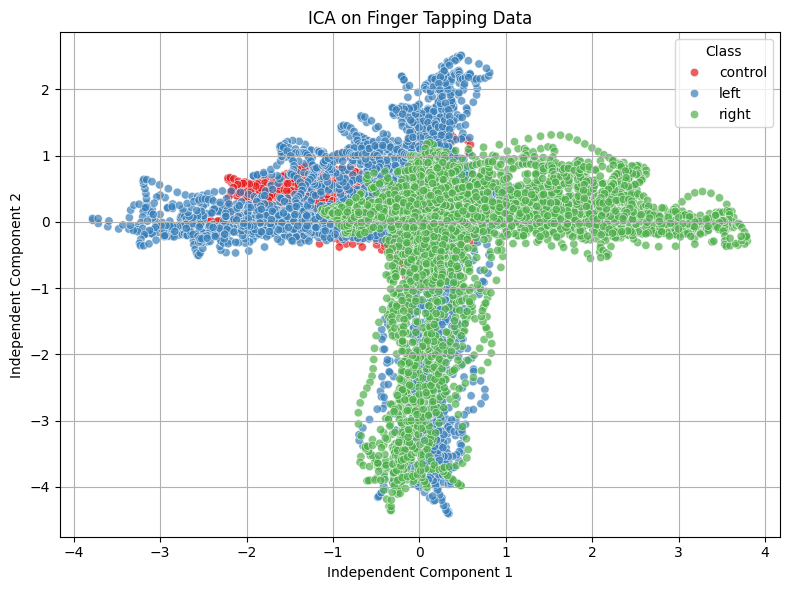

{'loc': array([-3.96163967e-02,  4.50141458e-02,  1.22816211e-01, -4.16132047e-02,
        2.67997753e-02,  1.29904394e-01, -3.76195887e-02,  6.32285163e-02,
        1.15728028e-01,  7.60000000e+02,             nan,             nan]), 'unit_mul': 0 (FIFF_UNITM_NONE), 'range': 1.0, 'cal': 1.0, 'kind': 1100 (FIFFV_FNIRS_CH), 'coil_type': 300 (FIFFV_COIL_FNIRS_HBO), 'unit': 6 (FIFF_UNIT_MOL), 'coord_frame': 4, 'ch_name': 'S1_D1 hbo', 'scanno': 1, 'logno': 1}


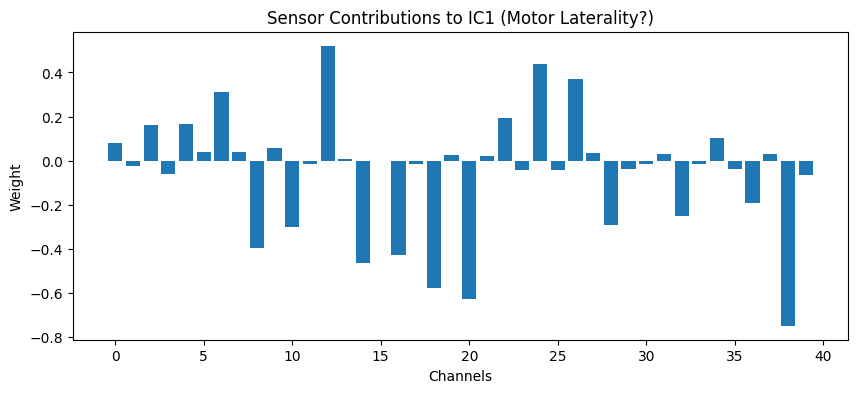

In [22]:

# Load data
# subject = simple_pipeline(subject="01")
subject = get_raw_subject_data(subject=0)
subject_data = subject.get_data()
y = subject.events[:, -1]

# Divide each activity
control = subject['Control']
left = subject['Tapping_Left']
right = subject['Tapping_Right']

# Find the activity with min amount of epochs
min_bound = np.min([x.get_data().shape[0] for x in [control, left, right]])

# Reshape function
def reshape_activity(epoch, min_bound):
    """Limit epochs to min bound, reshape data to channels x merged_epochs"""
    epoch_data = epoch.get_data()[:min_bound, :, :]
    # epoch_data = epoch.get_data()
    n_epoch, n_channels, n_epoch_size = epoch_data.shape
    epoch_data_reshaped = epoch_data.reshape(n_channels, n_epoch * n_epoch_size)
    return epoch_data_reshaped.T

# Reshape all activities
control_reshaped = reshape_activity(control, min_bound)
left_reshaped = reshape_activity(left, min_bound)
right_reshaped = reshape_activity(right, min_bound)

# Define input matrix
X = np.concatenate([control_reshaped, left_reshaped, right_reshaped], axis=0)

# Create labels
length = control_reshaped.shape[0]
y = np.concatenate([np.full(length, 1), np.full(length, 2), np.full(length, 3)])

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# X_scaled = X

# Apply ICA
ica = FastICA(n_components=5, max_iter=1000, tol=0.0001, random_state=42)
X_ica = ica.fit_transform(X_scaled)

# Prepare DataFrame
ica_df = pd.DataFrame(X_ica)
ica_df['label'] = y

# Label mapping
def set_label_name(x):
    if x == 1: return 'control'
    elif x == 2: return 'left'
    elif x == 3: return 'right'
    else: return np.nan

ica_df['label_name'] = ica_df['label'].apply(set_label_name)

# Select components to plot
ic_x = 0  # First component
ic_y = 1  # Second component

# Plot ICA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=ica_df, x=ic_x, y=ic_y, hue='label_name', alpha=0.7, palette="Set1")
plt.xlabel(f'Independent Component {ic_x + 1}')
plt.ylabel(f'Independent Component {ic_y + 1}')
plt.title('ICA on Finger Tapping Data')
plt.legend(title="Class")
plt.grid()
plt.tight_layout()
plt.show()

# Plot ICA component weights
print(subject.info['chs'][0])
plt.figure(figsize=(10, 4))
plt.bar(range(ica.mixing_.shape[0]), ica.mixing_[:, 0])
plt.title('Sensor Contributions to IC1 (Motor Laterality?)')
plt.xlabel('Channels')
plt.ylabel('Weight')
plt.show()

In [ ]:
def reshape_epochs(epochs, n_epochs_to_include):
    """
    Truncate the Epochs to a defined number and merge their time samples.
    
    Parameters:
        epochs (MNE Epochs): The epochs object containing the data.
        n_epochs_to_include (int): The maximum number of epochs to consider.
        
    Returns:
        ndarray: A 2D array where each row represents a time point (merged from epochs)
                 and each column corresponds to a channel.
    """
    # Retrieve and limit the epoch data
    
    """Limit epochs to min bound, reshape data to channels x merged_epochs"""
    epoch_data = epoch.get_data()[:min_bound, :, :]
    # epoch_data = epoch.get_data()
    n_epoch, n_channels, n_epoch_size = epoch_data.shape
    epoch_data_reshaped = epoch_data.reshape(n_channels, n_epoch * n_epoch_size)
    return epoch_data_reshaped.T

In [ ]:
# subject = simple_pipeline(subject="01")
epochs = get_raw_subject_data(subject=0)

# Divide each activity and find the minimum number of samples
control = epochs['Control']
left = epochs['Tapping_Left']
right = epochs['Tapping_Right']
min_bound = np.min([x.get_data().shape[0] for x in [control, left, right]])

# Reshape all activities
control_reshaped = reshape_activity(control, min_bound)
left_reshaped = reshape_activity(left, min_bound)
right_reshaped = reshape_activity(right, min_bound)
X = np.concatenate([control_reshaped, left_reshaped, right_reshaped], axis=0)

l = control_reshaped.shape[0]
y = np.concatenate([np.full(l, 1), np.full(l, 2), np.full(l, 3)])

# Standardize data (should not be necessary for ICA, but good practice)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Reading 0 ... 23238  =      0.000 ...  2974.464 secs...


In [27]:
ica = FastICA(n_components=5, max_iter=1000, tol=0.0001, random_state=42)
X_ica = ica.fit_transform(X_scaled)

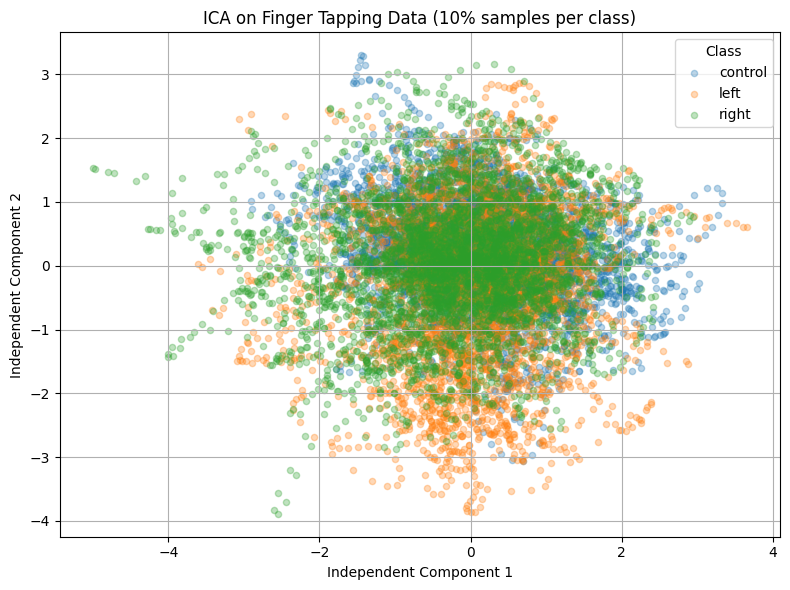

In [28]:
# Mapping labels to names and colors
labels_map = {1: "control", 2: "left", 3: "right"}
colors = {1: "C0", 2: "C1", 3: "C2"}

# Select components to plot
ic_x, ic_y = 0, 1

plt.figure(figsize=(8, 6))
for label in [1, 2, 3]:
    mask = (y == label)
    indices = np.where(mask)[0]
    # Select 10% of the indices (at least one)
    num_points = max(1, int(len(indices) * 1))
    selected = np.random.choice(indices, size=num_points, replace=False)
    plt.scatter(X_ica[selected, ic_x],
                X_ica[selected, ic_y],
                color=colors[label],
                alpha=0.3,
                label=labels_map[label],
                s=20)  # Adjusted size for better visibility

plt.xlabel(f'Independent Component {ic_x + 1}')
plt.ylabel(f'Independent Component {ic_y + 1}')
plt.title('ICA on Finger Tapping Data (10% samples per class)')
plt.legend(title="Class")
plt.grid()
plt.tight_layout()
plt.show()

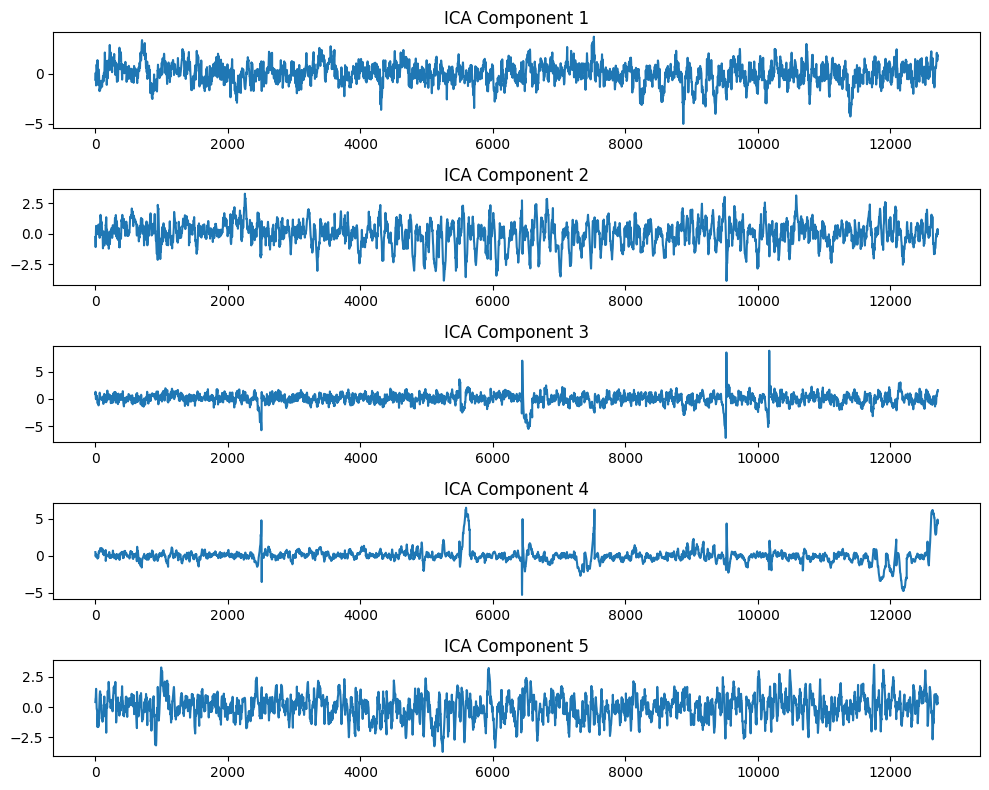

In [20]:
plt.figure(figsize=(10, 8))
for i in range(X_ica.shape[1]):
    plt.subplot(X_ica.shape[1], 1, i + 1)
    plt.plot(X_ica[:, i])
    plt.title(f'ICA Component {i + 1}')
plt.tight_layout()
plt.show()